In [76]:
import GPy
from pods.datasets import swiss_roll_generated
from GPy.models import BayesianGPLVM
import numpy as np
from sklearn.manifold.isomap import Isomap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # @UnusedImport

In [68]:
verbose=1
N=1000
num_inducing=25
Q=4
sigma=.2
n_samples, n_features = 1000, 3
n_turns, radius = 1.2, 1.0
rng = np.random.RandomState(0)
t = rng.uniform(low=0, high=1, size=n_samples)
data = np.zeros((n_samples, n_features))
max_rot = n_turns * 2 * np.pi
data[:, 0] = radius = t * np.cos(t * max_rot)
data[:, 1] = radius = t * np.sin(t * max_rot)
data[:, 2] = rng.uniform(-1, 1.0, n_samples)
manifold = np.vstack((t * 2 - 1, data[:, 2])).T.copy()
colors = manifold[:, 0]

In [59]:
Y = data
Y -= Y.mean()
Y /= Y.std()
iso = Isomap().fit(Y)

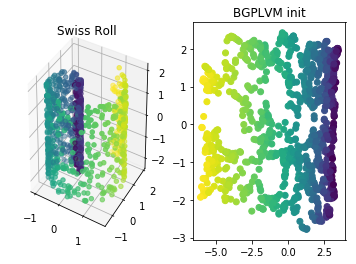

In [67]:
X = iso.embedding_
if Q > 2:
    X = np.hstack((X, np.random.randn(N, Q - 2)))

fig = plt.figure("Swiss Roll Data")
ax = fig.add_subplot(121, projection='3d')
ax.scatter(*Y.T, c=colors)
ax.set_title("Swiss Roll")
ax = fig.add_subplot(122)
ax.scatter(*X.T[:2], c=colors)
ax.set_title("BGPLVM init")
var = .5
S = (var * np.ones_like(X) + np.clip(np.random.randn(N, Q) * var ** 2,- (1 - var),(1 - var))) + .001
Z = np.random.permutation(X)[:num_inducing]
kernel = GPy.kern.RBF(Q, ARD=True) + GPy.kern.Bias(Q, np.exp(-2)) + GPy.kern.White(Q, np.exp(-2))

m = BayesianGPLVM(Y, Q, X=X, X_variance=S, num_inducing=num_inducing, Z=Z, kernel=kernel)
m.data_colors = colors
m.data_t = t


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s52  0006   3.561350e+03   4.264464e-02 
Runtime:     00s52
Optimization status: Converged



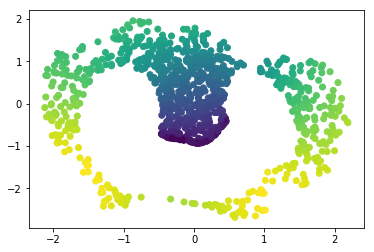

In [74]:
m.optimize('bfgs', messages=verbose, max_iters=2e3)
fig = plt.figure('fitted')
ax = fig.add_subplot(111)
s = m.input_sensitivity().argsort()[::-1][:2]
ax.scatter(*m.X.mean.T[s], c=colors)